<a href="https://colab.research.google.com/github/elainedias16/TCC/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BBC News Dataset

# Reading the Dataset and Creating the Dataframe

In [155]:
import pandas as pd

id_file = '1m41gWGwnLYo0nAEOABnU_MH_SCQHWfjS'
url_file = 'https://drive.google.com/uc?id={}'.format(id_file)

def create_dataframe(path):
    columns=['genre', 'filename', 'title', 'content']
    df =  pd.read_table(
    path,
    header=None,
    names=columns,
    sep= '\t',
    engine= 'python'
    )
    return df


df = create_dataframe(url_file)
df = df.drop(0).reset_index(drop=True)

df.tail()

,genre,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


In [ ]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import spacy
from spacy.lang.en.examples import sentences

!pip install unidecode
import unidecode
from nltk.stem.porter import PorterStemmer
!python -m spacy download en_core_web_sm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.4/12.8 MB 2.5 MB/s eta 0:00:05

## Rename filenames

In [ ]:
# In BBC dataset, some filenames have the same name, for example 001.txt, so it's necessary to rename
def rename_filenames(df):
  for index, row in df.iterrows():
      df.at[index, 'filename'] = f"{index}.txt"
  return df

df = rename_filenames(df)

## Create dataset with less samples

In [ ]:
import random

# def create_balanced_small_df(df, genres, num):
#   small_df_list = []
#   for genre in genres:
#     sample_rows = df.sample(num)
#     small_df_list.append(sample_rows)
#   return pd.concat(small_df_list).reset_index(drop=True)

def create_imbalanced_small_df(df, genres, max_value):
  small_df_list = []
  for genre in genres:
    qtd = random.randint(1, max_value)
    # print(qtd)
    sample_rows = df[df['genre'] == genre].sample(qtd)
    small_df_list.append(sample_rows)
  return pd.concat(small_df_list).reset_index(drop=True)


In [ ]:
genres = df['genre'].unique()
small_df = create_imbalanced_small_df(df, genres, max_value=15)
small_df

# Pre Processing

In [ ]:
def remove_non_alphanumeric(text):
    words = ''
    for w in text:
        words += w if w.isalnum() else ' '
    return words

def remove_accents(text):
  return unidecode.unidecode(text)


def lowercasting(tokens):
  tokens = [w.lower() for w in tokens]
  return tokens

def remove_stop_words(tokens):
  stop_words = set(stopwords.words('english')) #List of stop words in english
  tokens = [token for token in tokens if token not in stop_words]
  return tokens


def stemming(tokens):
  porter = PorterStemmer()
  tokens = [porter.stem(token) for token in tokens]
  return tokens


def lemmanization(text):
    nlp = spacy.load("en_core_web_sm")    # Load English language model
    doc = nlp(text)   # Process the text using the Spacy NLP
    tokens = [token.lemma_ for token in doc]
    return tokens


def pre_processing_aux(text):
  words = remove_non_alphanumeric(text)
  words = remove_accents(words)
  tokens = word_tokenize(words)
  tokens = lowercasting(tokens)
  tokens = remove_stop_words(tokens)
  words = ' '.join(tokens)
  tokens = lemmanization(words)
  tokens = stemming(tokens)
  return ' '.join(tokens)


In [161]:
def pre_processing(df):
    df['content'] = df['content'].apply(pre_processing_aux)
    return df

###########################################################
# To prossegue with all dataset, put df on parameter
# To prossegue with small dataset, put small_df in paramter
############################################################

df = pre_processing(small_df)
df.tail()

,genre,filename,title,content
58,tech,1996.txt,Supercomputer breaks speed record,we pois push japan top supercomput chart ibm p...
59,tech,2075.txt,Virus poses as Christmas e-mail,secur firm warn window viru disguis electron c...
60,tech,1897.txt,China 'to overtake US net use',chines net use popul look set exceed we less t...
61,tech,2147.txt,Apple attacked over sources row,civil liberti group electron frontier foundat ...
62,tech,1833.txt,Google's toolbar sparks concern,search engin firm googl releas trial tool conc...


# Basic statistics analysis

##Documents number by class

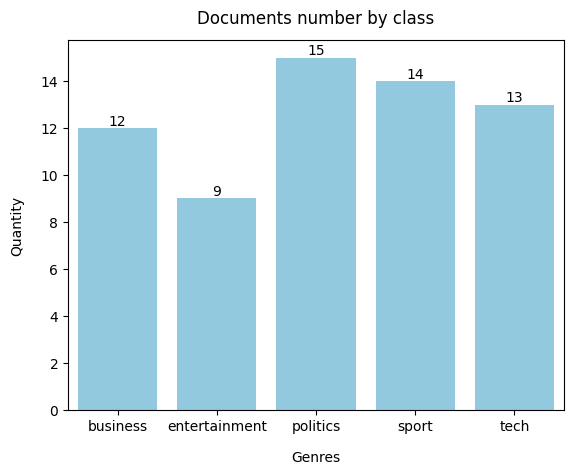

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

genres = df['genre'].unique()

def plot_doc_by_class(genres):
  ax = sns.countplot(x = 'genre', data = df , color='skyblue')
  ax.yaxis.grid(False)
  plt.title('Documents number by class', pad=12)
  plt.xlabel('Genres', labelpad=12)
  plt.ylabel('Quantity', labelpad=12)

  bars = ax.patches
  # Put numbers of docs above bars
  for bar in bars:
        height = int(bar.get_height())
        plt.text(bar.get_x() + bar.get_width()/2, height, height, ha='center', va='bottom')

  plt.show()


plot_doc_by_class(genres)

#Top 30 most frequent words

In [163]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn

def get_genre_content(df, genre):
  content = df.loc[df['genre'] == genre, 'content'].str.cat(sep=' ')
  return content

def create_dict_content(df):
  dict_content = {}
  for genre in genres:
      dict_content[genre] = get_genre_content(df, genre)
      if 'all' in dict_content:
        dict_content['all'] += get_genre_content(df, genre)
      else:
          dict_content['all'] = get_genre_content(df, genre)
  return dict_content

def create_count_content(dict_content):
  count_content = {}
  for genre, content in dict_content.items():
      count_content[genre] = Counter(content.split())
  return count_content


def get_top_n_words(top_n, count_words):
    most_common_words = {}
    for word, count in count_words.most_common(top_n):
        most_common_words[word] = count
    return most_common_words


In [164]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_h_most_common_words(top_n, count_content, genre, title, fontsize):
    most_common = get_top_n_words(top_n, count_content[genre])
    most_common = sorted(most_common.items(), key=lambda x: x[1])
    words = [item[0] for item in most_common ]
    counts = [item[1] for item in most_common ]
    plt.figure(figsize=(11, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Quantity', labelpad=15)
    plt.ylabel('Tokens', labelpad=15)
    plt.grid(False)
    plt.title(title, pad=15)
    #Display number of token in front of each bar
    for i in range(len(words)):
      plt.text(counts[i], i, ' ' + str(counts[i]), ha='left', va='center')

dict_content = create_dict_content(df)
count_content = create_count_content(dict_content)

In [165]:
print(count_content)

{'business': Counter({'say': 54, 'year': 30, 'economi': 20, 'growth': 20, 'econom': 18, '1': 18, 'would': 17, 'price': 15, 'also': 15, 'car': 15, 'deutsch': 14, 'boers': 14, 'fall': 13, 'high': 13, 'demand': 13, 'govern': 13, 'month': 13, 'rate': 13, 'deficit': 13, 'countri': 12, 'expect': 12, 'india': 12, 'bank': 11, 'meet': 11, '4': 10, '3': 10, 'exchang': 10, '2005': 10, 'sharehold': 10, 'could': 10, 'rise': 9, 'export': 9, '0': 9, 'forecast': 9, 'grow': 9, 'figur': 9, '2004': 9, 'one': 9, 'market': 9, '2': 9, 'compani': 9, 'new': 9, 'tobacco': 9, 'quarter': 8, 'last': 8, 'share': 8, 'nation': 8, 'budget': 8, '5': 8, 'tci': 8, 'good': 8, 'state': 8, 'industri': 7, 'output': 7, 'domest': 7, 'analyst': 7, 'time': 7, 'friday': 7, 'mr': 7, 'uk': 7, 'lse': 7, 'see': 7, 'law': 7, 'park': 7, 'argentina': 7, '6': 6, 'slow': 6, 'weak': 6, 'may': 6, 'offici': 6, 'london': 6, 'unit': 6, 'group': 6, 'we': 6, 'interest': 6, 'plan': 6, 'takeov': 6, 'offer': 6, 'bid': 6, 'investor': 6, 'us': 6, 'b

##Top 30 most frequent tokens in business

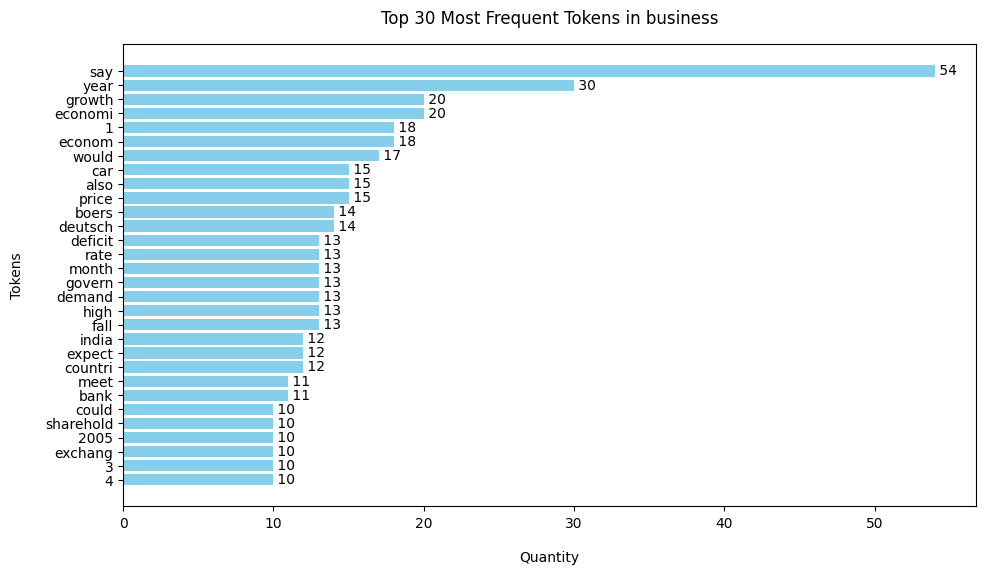

In [166]:
top_n = 30
fontsize = 12
title_business = 'Top {} Most Frequent Tokens in business'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'business', title_business, fontsize)
# common_words_business = get_top_n_words(top_n, count_content['business'])
# print(common_words_business)

##Top 30 most frequent tokens in entertainment




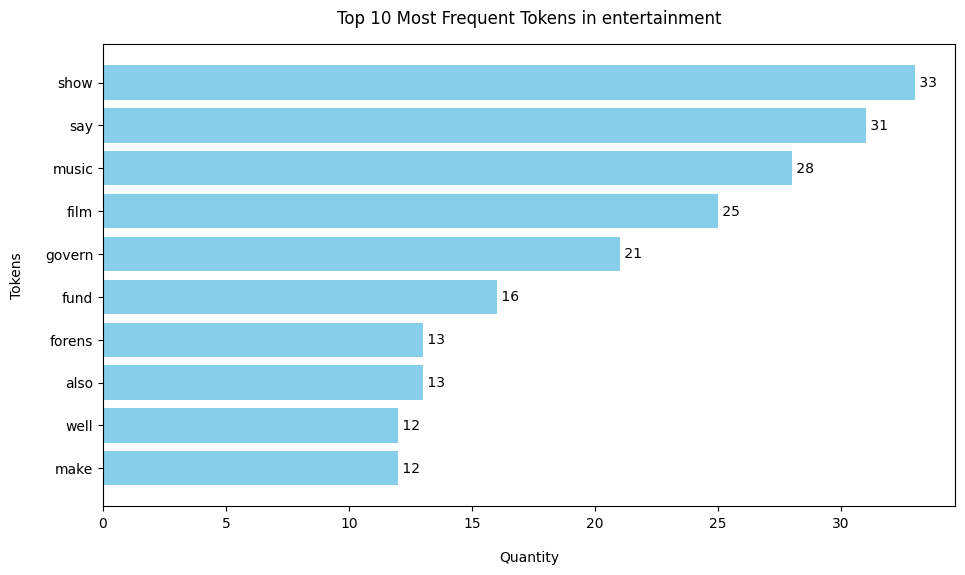

In [167]:
top_n = 10
fontsize = 12
title_entertainment = 'Top {} Most Frequent Tokens in entertainment'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'entertainment', title_entertainment, fontsize)
# common_words_entertainment = get_top_n_words(top_n, count_content['entertainment'])
# print(common_words_entertainment)

##Top 30 most frequent tokens in politics

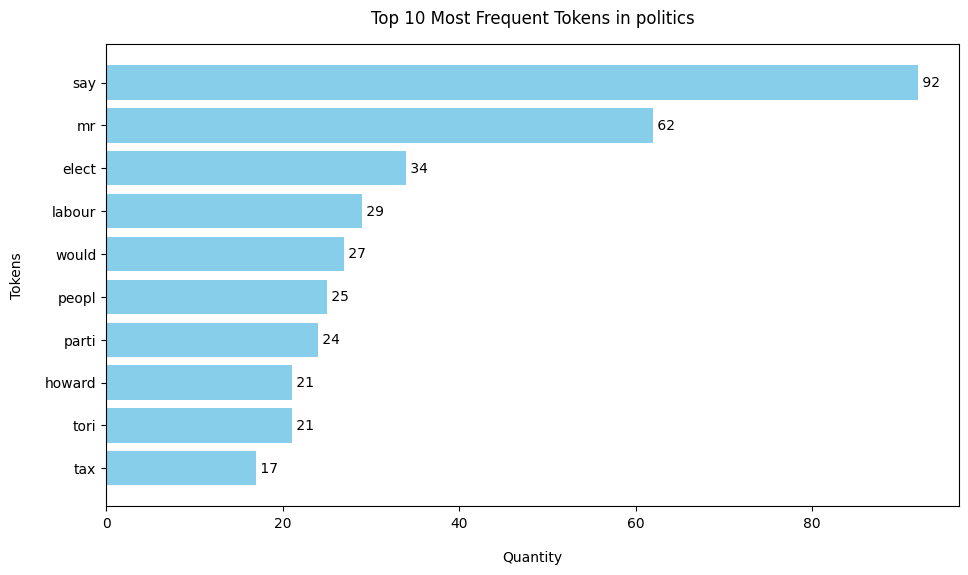

In [168]:
top_n = 10
fontsize = 12
title_politics = 'Top {} Most Frequent Tokens in politics'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'politics', title_politics, fontsize)
# common_words_politics = get_top_n_words(top_n, count_content['politics'])
# print(common_words_politics)

##Top 30 most frequent tokens in sport

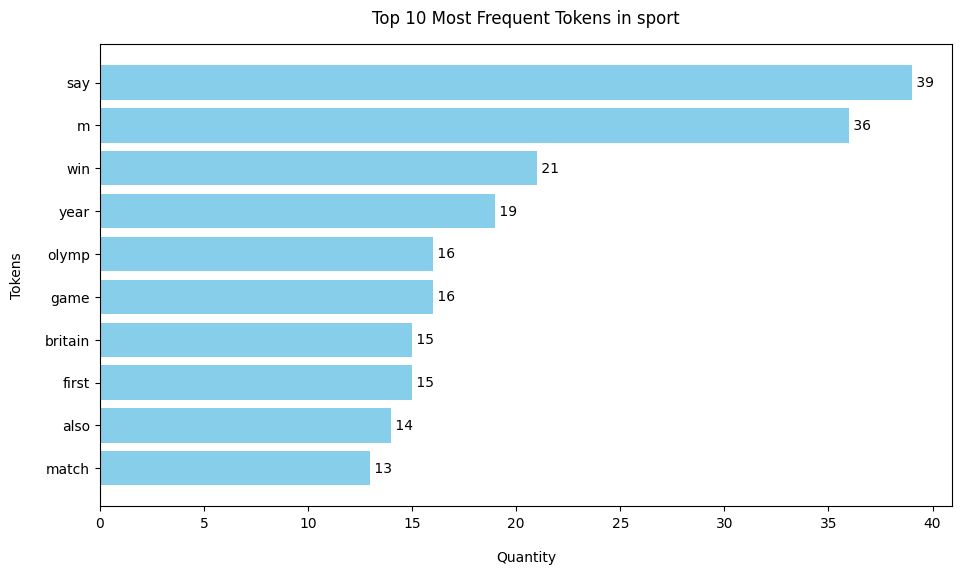

In [169]:
top_n = 10
fontsize = 12
title_sport = 'Top {} Most Frequent Tokens in sport'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'sport', title_sport, fontsize)
# common_words_sport = get_top_n_words(top_n, count_content['sport'])
# print(common_words_sport)

##Top 30 most frequent tokens in tech

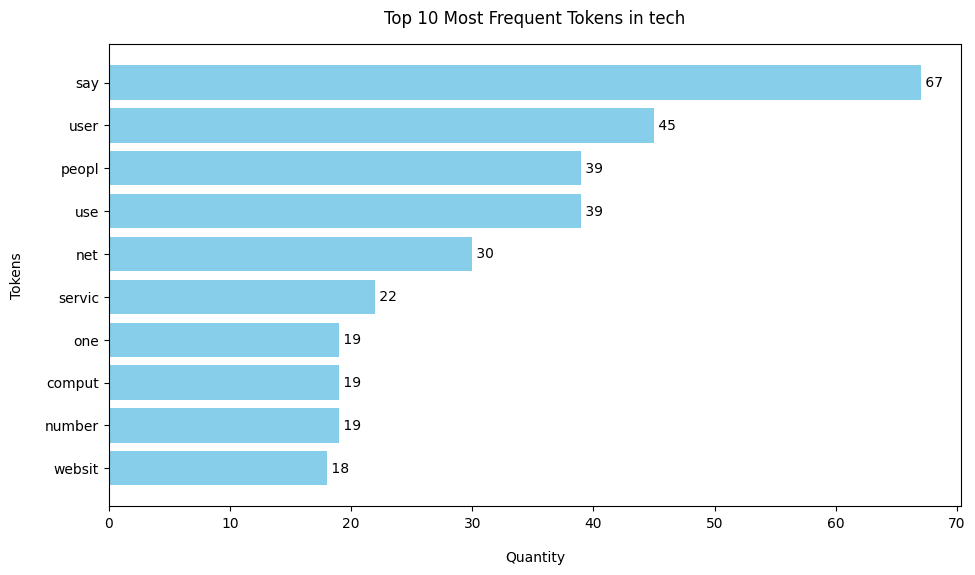

In [170]:
top_n = 10
fontsize = 12
title_tech = 'Top {} Most Frequent Tokens in tech'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'tech', title_tech, fontsize)
# common_words_tech = get_top_n_words(top_n, count_content['tech'])
# print(common_words_politics)

##Top 30 most frequent tokens in all dataset

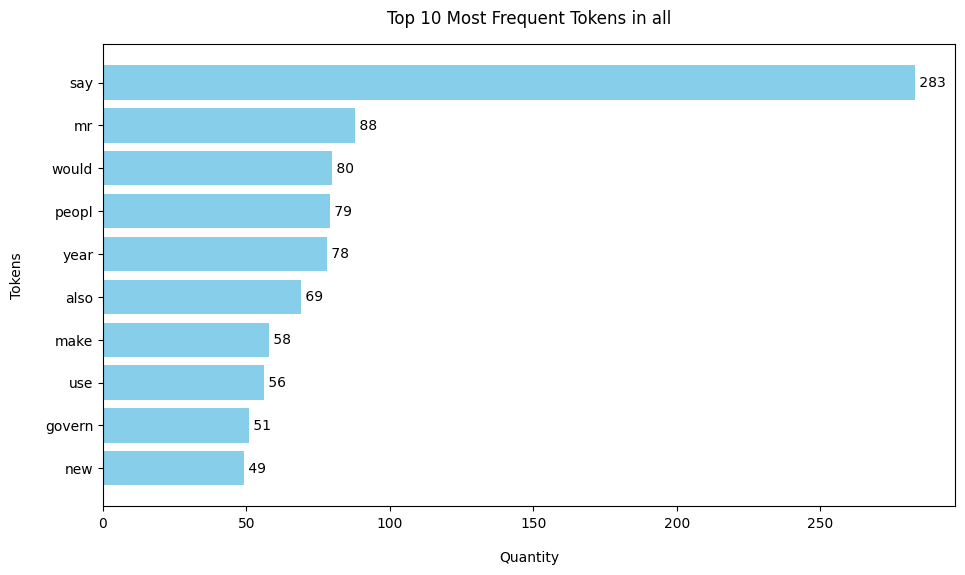

In [171]:
top_n = 10
fontsize = 12
title_all = 'Top {} Most Frequent Tokens in all'.format(top_n)
plot_h_most_common_words(top_n, count_content, 'all', title_all, fontsize)
# common_words_all = get_top_n_words(top_n, count_content['all'])
# print(common_words_all)

#Frequency of class by word

In [172]:
import random

#Choose 10 random tokens in all content of news
random_words = random.sample(dict_content['all'].split(), 3)
print("random words: ", random_words)

def get_counts_by_genre(word, count_genres):
    counts_by_genre = {}  #Dictionary to store word count in each class
    for genre, content_counter in count_genres.items():
        if word in content_counter:
            counts_by_genre[genre] = content_counter[word]  # Adds the word count in the class to the dictionary
    return counts_by_genre


def get_frequency_class_by_word(selected_words, count_genres):
    dict_frequency = {}
    for word in selected_words:
        dict_frequency[word] = get_counts_by_genre(word, count_genres)
    return dict_frequency


dict_frequency = get_frequency_class_by_word(random_words, count_content)
print(dict_frequency)

random words:  ['intern', 'nation', 'drop']
{'intern': {'business': 2, 'all': 11, 'politics': 4, 'sport': 3, 'tech': 2}, 'nation': {'business': 8, 'all': 26, 'entertainment': 1, 'politics': 8, 'sport': 2, 'tech': 8}, 'drop': {'business': 1, 'all': 6, 'entertainment': 2, 'sport': 2, 'tech': 1}}


In [173]:
#Testing
df[df['genre']=='politics']

,genre,filename,title,content
21,politics,917.txt,"Nat Insurance to rise, say Tories",nation insur rais labour win next elect tori l...
22,politics,1045.txt,Galloway plea for hostage release,ex labour mp georg galloway appeal releas aid ...
23,politics,1208.txt,Parties warned over 'grey vote',polit parti afford take old uk voter grant com...
24,politics,1049.txt,Mayor will not retract Nazi jibe,london mayor ken livingston refus retract nazi...
25,politics,1172.txt,Howard and Blair tax pledge clash,toni blair say voter wait labour manifesto see...
26,politics,1311.txt,Top Tories on Lib Dem 'hit list',liber democrat aim unseat string top tori incl...
27,politics,911.txt,Crisis 'ahead in social sciences',nation bodi design tackl skill shortag key sub...
28,politics,914.txt,Drink remark 'acts as diversion',first minist statement okay get drunk divert a...
29,politics,1053.txt,"Petrol duties frozen, Brown says",chancellor gordon brown announc freez fuel dut...
30,politics,969.txt,BNP leader Nick Griffin arrested,leader british nation parti arrest part polic ...


# Frequency of words by documents

In [174]:
from collections import Counter

def get_frequency(df):
    frequency = {}
    for index, row in df.iterrows():
        filename = row['filename']
        word_counts = dict(Counter(row['content'].split()))
        if filename not in frequency:
          frequency[filename] = word_counts
    return frequency



frequency = get_frequency(df)
print(frequency)


{'45.txt': {'japanes': 2, 'industri': 3, 'output': 2, 'fall': 5, 'octob': 3, 'unemploy': 3, 'rise': 4, 'cast': 1, 'doubt': 1, 'strength': 1, 'countri': 1, 'econom': 3, 'recoveri': 1, 'product': 1, 'drop': 1, '1': 4, '6': 2, 'reflect': 1, 'declin': 2, 'export': 1, 'level': 1, 'edg': 1, '0': 4, '4': 1, '7': 2, 'slightli': 1, 'high': 3, 'forecast': 2, 'economi': 4, 'grow': 1, 'six': 1, 'quarter': 4, 'growth': 2, 'slow': 2, 'dramat': 1, 'last': 1, 'amid': 1, 'weak': 2, 'global': 1, 'demand': 4, 'japan': 2, 'govern': 2, 'remain': 1, 'optimist': 1, 'due': 1, 'strong': 2, 'domest': 2, 'analyst': 1, 'month': 5, 'accord': 1, 'figur': 2, 'ministri': 1, 'trade': 2, 'meti': 2, 'lead': 1, 'electron': 1, 'part': 1, 'mobil': 1, 'phone': 1, 'digit': 1, 'televis': 1, 'although': 1, 'inventori': 1, '36': 1, 'year': 3, 'ago': 1, 'sign': 1, 'adjust': 1, 'phase': 1, 'expect': 1, 'say': 3, 'takashi': 1, 'yamanaka': 1, 'economist': 1, 'ufj': 1, 'bank': 1, 'downgrad': 1, 'overal': 1, 'assess': 1, 'earli': 1, 

In [175]:
df[df['filename']=='253.txt']

,genre,filename,title,content


# Word Index by documents





In [176]:
def create_word_index(df):
    h = {}
    for index, row in df.iterrows():
        filename = row['filename']
        content = row['content']
        words = content.split()
        for word in words:
            if word not in h:
                h[word] = {}

            if filename not in h[word]:
                h[word][filename] = 1
            else:
                h[word][filename] += 1
    return h

word_index = create_word_index(df)
print(word_index)

{'japanes': {'45.txt': 2, '155.txt': 1}, 'industri': {'45.txt': 3, '290.txt': 1, '155.txt': 3, '640.txt': 4, '911.txt': 1}, 'output': {'45.txt': 2, '136.txt': 1, '171.txt': 1, '155.txt': 3, '640.txt': 2}, 'fall': {'45.txt': 5, '136.txt': 3, '171.txt': 4, '155.txt': 1, '735.txt': 2, '917.txt': 2, '1378.txt': 1}, 'octob': {'45.txt': 3, '136.txt': 1, '1045.txt': 1, '1546.txt': 1, '2220.txt': 1, '1996.txt': 1}, 'unemploy': {'45.txt': 3}, 'rise': {'45.txt': 4, '453.txt': 1, '183.txt': 1, '290.txt': 1, '460.txt': 1, '155.txt': 1, '718.txt': 1, '733.txt': 1, '1053.txt': 2, '2220.txt': 1}, 'cast': {'45.txt': 1}, 'doubt': {'45.txt': 1, '1015.txt': 1, '1378.txt': 1, '2057.txt': 1}, 'strength': {'45.txt': 1, '171.txt': 1}, 'countri': {'45.txt': 1, '7.txt': 3, '171.txt': 3, '53.txt': 1, '155.txt': 1, '92.txt': 3, '702.txt': 1, '917.txt': 2, '911.txt': 1, '1237.txt': 1, '1015.txt': 1, '2057.txt': 1, '1897.txt': 3}, 'econom': {'45.txt': 3, '7.txt': 2, '136.txt': 3, '487.txt': 2, '171.txt': 7, '155.t

In [177]:
df[df['filename']=='253.txt']

,genre,filename,title,content


# Seach

## Pre processing in seach query

In [178]:
query = 'russian movie'
query = pre_processing_aux(query)
print(query)

russian movi


## Search query

In [179]:
def get_frequency_query(query, word_index):
    query_index = {}
    for word in query.split():
        if word in word_index:
            query_index[word] = word_index[word]
    return query_index


index_query = get_frequency_query(query, word_index)
print(index_query)


def sum_occurrences(index_query):
    f = {}
    for word_dict in index_query.values():
        for filename, count in word_dict.items():
            if filename not in f:
                f[filename] = count
            else:
                f[filename] += count

    return f

occurrences = sum_occurrences(index_query)
print(occurrences)

{'russian': {'1387.txt': 1, '1814.txt': 1, '1378.txt': 2, '1943.txt': 2}, 'movi': {'563.txt': 2, '556.txt': 1, '1898.txt': 2}}
{'1387.txt': 1, '1814.txt': 1, '1378.txt': 2, '1943.txt': 2, '563.txt': 2, '556.txt': 1, '1898.txt': 2}


In [180]:
def sort_sum_occurrences(occurrences):
  sorted_occurences = sorted(occurrences.items(), key=lambda x : x[1], reverse=True) #reverse is descr order
  return sorted_occurences


def get_top_n_docs(occurences, top_n):
  occurences = dict(occurences)
  docs = list(occurences.keys())[:top_n]
  return docs

sorted_occurences = sort_sum_occurrences(occurrences)
print(sorted_occurences)

top_n = 5
docs = get_top_n_docs(sorted_occurences, top_n)
print(docs)

[('1378.txt', 2), ('1943.txt', 2), ('563.txt', 2), ('1898.txt', 2), ('1387.txt', 1), ('1814.txt', 1), ('556.txt', 1)]
['1378.txt', '1943.txt', '563.txt', '1898.txt', '1387.txt']


# Classifier

## Define test and training set

In [181]:
from sklearn.model_selection import train_test_split

def create_test_training_split(df, percent):
    train_dfs = []
    test_dfs = []
    grouped = df.groupby('genre')
    for genre, group_df in grouped:
        train_df, test_df = train_test_split(group_df, test_size=percent, random_state=42)
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    train_df = pd.concat(train_dfs).reset_index(drop=True)
    test_df = pd.concat(test_dfs).reset_index(drop=True)
    return train_df, test_df
    # X_train = pd.concat(train_dfs).reset_index(drop=True).drop('genre')
    # y_train = pd.concat(train_dfs)['genre'].reset_index(drop=True)
    # X_test = pd.concat(test_dfs).reset_index(drop=True).drop('genre')
    # y_test = pd.concat(test_dfs)['genre'].reset_index(drop=True)
    # return X_train, y_train, X_test, y_test



percent_test = 0.2
train_df, test_df = create_test_training_split(df, percent_test)
# X_train, y_train, X_test, y_test = create_test_training_split(df, percent_test)

In [182]:
train_df, test_df = create_test_training_split(df, percent_test)

In [183]:
train_df.shape[0]

49

## Create dictionary for different words in training set

In [191]:
# def create_unique_words(content):
#   words = content.split()
#   #set function doesn't differentiate between uppercase/lowercase and accents,
#   #so it's necessary to preprocess first
#   return set(words)

# content_train = train_df['content'].str.cat(sep=' ')
# unique_words_set_train = create_unique_words(content_train)

# print(unique_words_set_train)
# print(len(unique_words_set_train))

def create_unique_words(content):
  words = content.split()
  dict_words = dict(Counter(words))
  return dict_words


content_train = train_df['content'].str.cat(sep=' ')
unique_words_set_train = create_unique_words(content_train)

print(unique_words_set_train)
print(len(unique_words_set_train))

{'european': 9, 'union': 5, 'new': 38, 'member': 5, 'bolster': 1, 'europ': 6, 'econom': 16, 'growth': 16, '2005': 12, 'accord': 10, 'report': 19, 'eight': 3, 'central': 4, 'state': 15, 'join': 6, 'eu': 3, 'last': 24, 'year': 56, 'see': 25, '4': 15, '6': 11, 'unit': 8, 'nation': 23, 'commiss': 4, 'unec': 5, 'say': 236, 'contrast': 2, '12': 4, 'euro': 5, 'zone': 2, 'countri': 16, 'put': 13, 'lacklustr': 1, 'perform': 6, 'gener': 21, '1': 22, '8': 6, 'global': 7, 'economi': 16, 'slow': 5, 'forecast': 9, 'due': 13, 'widespread': 2, 'weak': 2, 'consum': 8, 'demand': 8, 'warn': 8, 'could': 24, 'also': 57, 'threaten': 3, 'attempt': 2, 'reduc': 8, 'huge': 9, 'current': 6, 'account': 6, 'deficit': 13, 'turn': 2, 'might': 6, 'lead': 11, 'signific': 4, 'volatil': 3, 'exchang': 11, 'rate': 23, 'averag': 6, '2': 16, 'across': 8, 'howev': 14, 'total': 8, 'output': 4, 'fall': 10, '2004': 12, '9': 6, 'larg': 11, 'falter': 1, 'german': 6, 'shrink': 1, '0': 5, 'quarter': 4, 'monday': 8, 'germani': 4, 'b

## Tranform each doc in a vector

## Binary

In [ ]:
def create_binary_array_doc_aux(content, unique_words):
    tokens = content.split()
    binary_array = []
    for word in unique_words.keys():
        if word in tokens:
            binary_array.append(1)
        else:
            binary_array.append(0)
    return binary_array


def create_binary_array_doc(df, unique_words):
    binary_words_array = {}
    for index, row in df.iterrows():
        filename = row['filename']
        content = row['content']
        binary_array = create_binary_array_doc_aux(content, unique_words)
        binary_words_array[filename] = binary_array

    return binary_words_array


binary_word_array = create_binary_array_doc(train_df, unique_words_set_train)
binary_word_array

In [190]:
#################### Testing ###########################
def count_ones(vector):
  count = 0
  for element in vector:
    if element == 1:
      count += 1
  return count

num = '171.txt'

#print binray array of 216.txt file
print(f"Binary array of {num} file: {binary_word_array[num]}")

# print len of binary_word_array and unique_words_set_train. The size should be the same
print(f"Size of binary_word_vector of file {num} : {len(binary_word_array[num])}")
print(f"Size of unique_words_set_train : {len(unique_words_set_train)}")

content_file = train_df[train_df['filename'] == num]['content'].values[0]
# content_377
unique_words_file = create_unique_words(content_file)
# print(unique_words_file)
print(f"Size of unique_words of file: {len(unique_words_file)}")

# The qtd of ones should be the same of unique_words file
num_ones = count_ones(binary_word_array[num])
print(f"Number of ones in the vector: {num_ones}")

Binary array of 171.txt file: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Frequency of word in docs

In [ ]:
# frequency_word_docs

# def create_word_frequency_aux(content, unique_words):
#     word_frequency = [0] * len(unique_words_set_train)
#     tokens = content.split()
#     for word in unique_words.keys():
#         if word in tokens:
#             word_frequency[word] = quantidade da palavra no tokens

#     return word_frequency

def create_word_frequency_aux(content, unique_words):
    word_frequency = [0] * len(unique_words)
    tokens = content.split()
    for i, word in enumerate(unique_words):
        if word in tokens:
            word_frequency[i] = tokens.count(word)
    return word_frequency